In [1]:
import os
print(os.getcwd())  # this is where Jupyter is looking from
#one folder back
os.chdir('..')
print(os.getcwd())

/root/n1_masters_thesis/model_training
/root/n1_masters_thesis


In [2]:
import pandas as pd
import numpy as np
from load_data import load_dataset, ImageDataset

from split import get_dataloaders
from custom_data_aug import get_transforms
from auto_aug import get_autoaugment_transforms

import torch
import torch.nn as nn
import torchvision
from config import CFG

from torchinfo import summary

from torch.utils.tensorboard import SummaryWriter
from training import train  # or wherever your updated function lives

from acc_loss_plot import plot_training_curves

In [3]:
# Load the dataframe
csv_path = "/root/n1_masters_thesis/filtered_df.csv"
image_dir = "/root/n1_masters_thesis/image_data/image_data"
df, idx_to_label = load_dataset(csv_path, image_dir)

In [4]:
print(df.head())

                                           file_name label  label_idx
0  /root/n1_masters_thesis/image_data/image_data/...    BC          0
1  /root/n1_masters_thesis/image_data/image_data/...    BC          0
2  /root/n1_masters_thesis/image_data/image_data/...    BC          0
3  /root/n1_masters_thesis/image_data/image_data/...    BC          0
4  /root/n1_masters_thesis/image_data/image_data/...    BC          0


In [4]:
train_transforms, val_transforms = get_autoaugment_transforms()

train_dataset, val_dataset, train_loader, val_loader = get_dataloaders(
    df, train_transforms, val_transforms
)

In [7]:
def build_model(device: torch.device, num_classes: int = CFG.NUM_CLASSES) -> nn.Module:
    # Set seeds
    torch.manual_seed(CFG.SEED)
    torch.cuda.manual_seed(CFG.SEED)

    weights = torchvision.models.ResNet50_Weights.DEFAULT
    model = torchvision.models.resnet50(weights=weights).to(device)

    for param in model.parameters():
        param.requires_grad = False

    for param in model.layer3.parameters():
        param.requires_grad = True
    
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
        nn.Linear(2048, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(512, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, num_classes)
    ).to(device)

    return model

In [8]:
cnn = build_model(device=CFG.DEVICE)

# View model summary
summary(
    model=cnn, 
    input_size=(CFG.BATCH_SIZE, CFG.CHANNELS, CFG.WIDTH, CFG.HEIGHT),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 34]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [9]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss(
    label_smoothing=0.1
)

# Define Optimizer
optimizer = torch.optim.Adam(
    cnn.parameters(),
    lr=CFG.LR
)

In [10]:
writer = SummaryWriter(log_dir="runs/exp1_efficientnet")

session = train(
    model=cnn,
    train_dataloader=train_loader,
    eval_dataloader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=CFG.EPOCHS,
    device=CFG.DEVICE,
    writer=writer
)

writer.close()


Epoch 1/30


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 2.3832 - top1: 0.3302 - top5: 0.7525 - eval_loss: 1.6419 - eval_top1: 0.5699 - eval_top5: 0.9614

Epoch 2/30


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.6554 - top1: 0.5834 - top5: 0.9477 - eval_loss: 1.4619 - eval_top1: 0.6532 - eval_top5: 0.9734

Epoch 3/30


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.4558 - top1: 0.6775 - top5: 0.9634 - eval_loss: 1.3426 - eval_top1: 0.7150 - eval_top5: 0.9772

Epoch 4/30


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.3487 - top1: 0.7238 - top5: 0.9739 - eval_loss: 1.2865 - eval_top1: 0.7407 - eval_top5: 0.9772

Epoch 5/30


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.2704 - top1: 0.7626 - top5: 0.9798 - eval_loss: 1.2961 - eval_top1: 0.7452 - eval_top5: 0.9748

Epoch 6/30


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.2163 - top1: 0.7818 - top5: 0.9841 - eval_loss: 1.2480 - eval_top1: 0.7541 - eval_top5: 0.9844

Epoch 7/30


  0%|          | 0/233 [00:00<?, ?it/s]

loss: 1.1531 - top1: 0.8149 - top5: 0.9859 - eval_loss: 1.3142 - eval_top1: 0.7380 - eval_top5: 0.9736

Epoch 8/30


  0%|          | 0/233 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
# Convert history dict to DataFrame
session_history_df = pd.DataFrame(session)
session_history_df

,loss,accuracy,top5_accuracy,eval_loss,eval_accuracy,eval_top5_accuracy
0,2.424760,0.328889,0.735622,1.734930,0.514423,0.933494
1,1.763725,0.549464,0.932806,1.467725,0.654647,0.971154
2,1.596173,0.622398,0.953702,1.449479,0.648638,0.968750
3,1.488159,0.675644,0.963224,1.338938,0.714343,0.972356
4,1.410282,0.707484,0.969689,1.298120,0.730369,0.980769
5,1.362747,0.732940,0.969957,1.308984,0.715545,0.979567
6,1.334831,0.737741,0.975590,1.279300,0.739583,0.985577
7,1.308632,0.753836,0.980016,1.230092,0.748397,0.983173
8,1.259877,0.772586,0.979882,1.293578,0.741987,0.974760
9,1.249900,0.778273,0.982430,1.316188,0.721955,0.979567


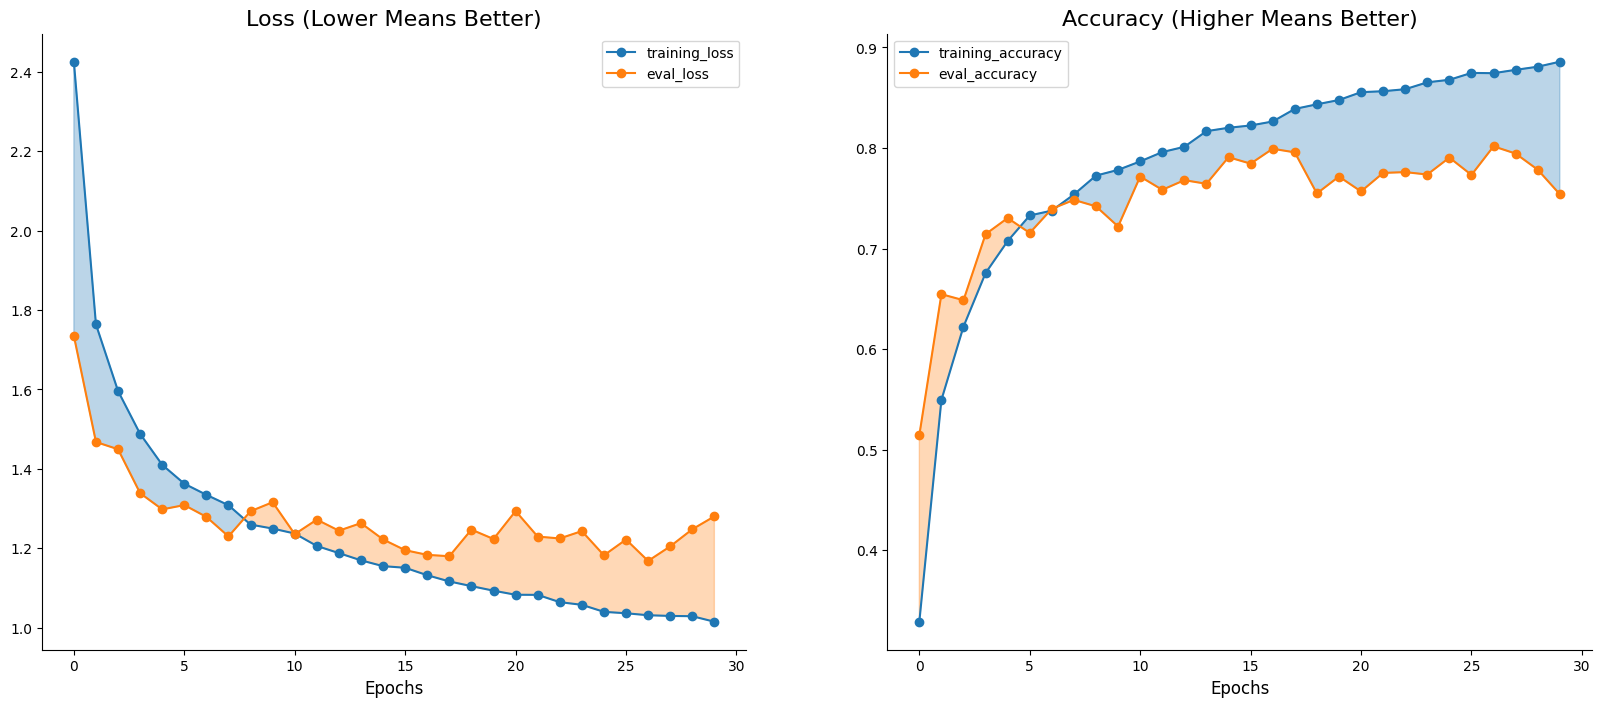

In [16]:
from acc_loss_plot import plot_training_curves
# Plot EfficientNet session training history 
plot_training_curves(session)